# Datensätze mit den größten Vorhersagefehlern (SVR)

In [1]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from sklearn.experimental import enable_halving_search_cv
from sklearn import model_selection, svm, metrics, manifold, preprocessing
import joblib

import prepare

In [2]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']
DATA_ALL = DATA_OK + DATA_FEHLER

In [3]:
DATA_ALL

['ok',
 'near_ok_sonowechsel',
 'fehler_oel',
 'fehler_leitungsversatz',
 'fehler_terminversatz']

In [4]:
zugversuche, kurven = prepare.read_all(BASE_DIR, DATA_ALL)

ok_: count 200 rows 1407...1650
near_ok_sonowechsel_: count 100 rows 1582...1759
fehler_oel_: count 100 rows 1052...1434
fehler_leitungsversatz_: count 100 rows 1716...2403
fehler_terminversatz_: count 100 rows 1702...2092


Debugausgabe

In [5]:
zugversuche

,nr,festigkeit,key,label,label_text
0,1569,2600.000000,ok_1569,0,ok
1,1570,2750.000000,ok_1570,0,ok
2,1571,2770.000000,ok_1571,0,ok
3,1572,2660.000000,ok_1572,0,ok
4,1573,2810.000000,ok_1573,0,ok
...,...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4,fehler_terminversatz
596,2506,2085.117920,fehler_terminversatz_2506,4,fehler_terminversatz
597,2507,2237.231201,fehler_terminversatz_2507,4,fehler_terminversatz
598,2508,2406.469482,fehler_terminversatz_2508,4,fehler_terminversatz


In [6]:
versuche_train, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2, random_state=42)
versuche_train.shape, versuche_test.shape

((480, 5), (120, 5))

Umwandeln in statistische Features

In [7]:
stat_feat = prepare.StatFeatures2()
stat_feat.fit() # dummy

StatFeatures2()

In [8]:
X_train = stat_feat.transform(versuche_train.key, kurven)
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values
print(X_train.shape, label_train.shape)

(480, 19) (480,)


In [9]:
X_test = stat_feat.transform(versuche_test.key, kurven)
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values
print(X_test.shape)
print(X_test.max(axis=(0,1)))
#festigkeit_train

(120, 19)
3551.38


Skalieren Trainingsdaten

In [10]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)

Skalieren Testdaten

In [11]:
X_test_scaled = std_scaler.transform(X_test)

Kontrollanzeige t-SNE

In [12]:
X_train_projected = manifold.TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_train_scaled)

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Klassen')

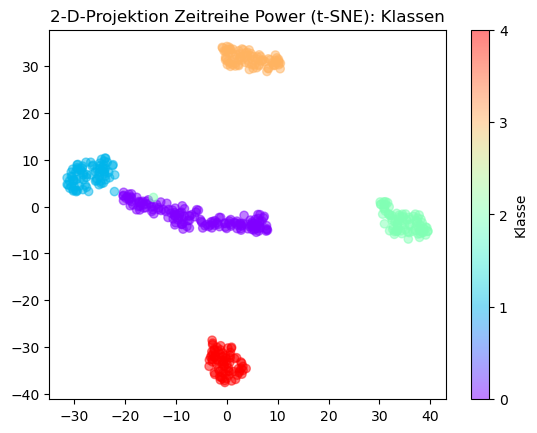

In [13]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], c=label_train, cmap='rainbow', alpha=0.5)
plt.colorbar(label='Klasse', ticks=[0,1,2,3,4,5])
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Klassen')

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

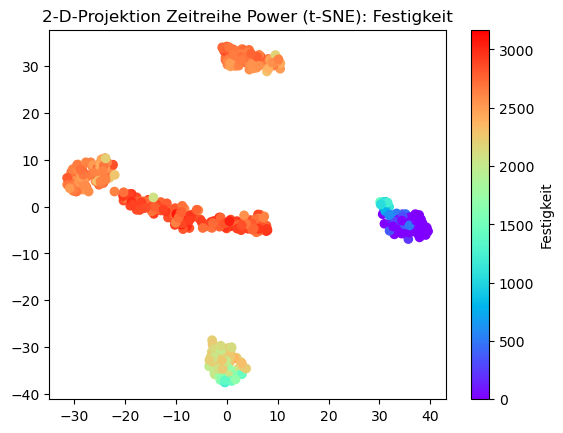

In [14]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], c=festigkeit_train, cmap='rainbow')
plt.colorbar(label='Festigkeit')
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

Hyperparameter SVR

In [15]:
params = {
    #'C': scipy.stats.expon(100),
    #'gamma': scipy.stats.expon(0.01),
    'C': np.logspace(0, 5),      # 50 Werte zwischen 1 und 10000
    'gamma': np.logspace(-5, 1), # 50 Werte zwischen 1e-5 und 10
    'epsilon': np.logspace(-2, 2) # 50 Werte zwischen 0.01 und 100
}
# experimental, results not very stable!
estim2 = model_selection.HalvingRandomSearchCV(
    svm.SVR(),
    params,
    n_candidates='exhaust',
    factor=2,
    #verbose=3,
)
# alternativ RandomSearch
estim3 = model_selection.RandomizedSearchCV(
    svm.SVR(),
    params,
    n_iter=500, # ATTENTION: runs very long
    n_jobs=-1,
)
estim3.fit(X_train_scaled, festigkeit_train)
print('Best parameters:', estim3.best_params_)
best_estim = estim3.best_estimator_


Best parameters: {'gamma': 0.026826957952797246, 'epsilon': 68.66488450042998, 'C': 9540.954763499944}


*Beobachtung*: sehr großer Wert für *C*.

Eventuell Verbesserung durch Skalieren der Zielgröße (statt `festigkeit` besser `festigkeit/2000` vorhersagen?

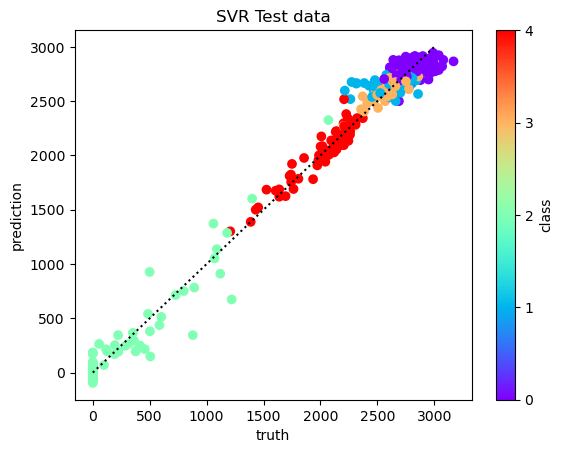

In [16]:
y_pred_train = best_estim.predict(X_train_scaled)
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5), label='class')
#plt.savefig('svr_randsearch_train.png')

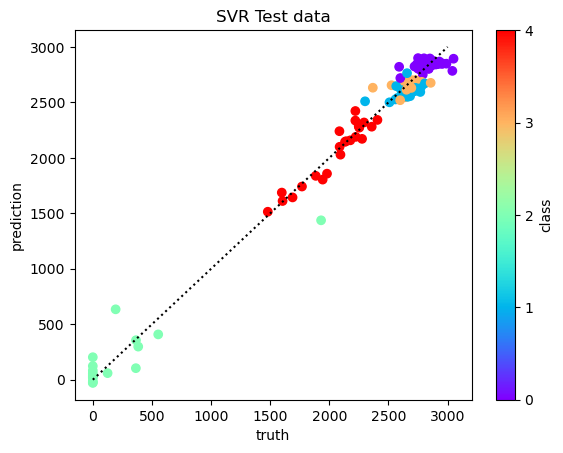

In [17]:
y_pred_test = best_estim.predict(X_test_scaled)
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5), label='class')
#plt.savefig('svr_randsearch_test.png')

In [18]:
y_pred_train = best_estim.predict(X_train_scaled)
y_pred_test = best_estim.predict(X_test_scaled)
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")
# mapi ist nutzlos durch 0-Werte bei Zugfestigkeit
#mapi_train = metrics.mean_absolute_percentage_error(festigkeit_train, y_pred_train)
#mapi_test = metrics.mean_absolute_percentage_error(festigkeit_test, y_pred_test)
#print(f"MAPI: train {mapi_train:8.1f}, test: {mapi_test:8.1f}")



MSE: train  11763.5, test:  12128.8
RMSE: train    108.5 test:    110.1
MAE: train     80.2, test:     77.1


In [19]:
result_train = versuche_train[['key', 'label', 'festigkeit']].copy()
result_train['pred'] = y_pred_train
result_train['abs_err'] = (result_train.festigkeit - result_train.pred).abs()
for (i, col) in enumerate([
    'p_mean', 'p_q25', 'p_50', 'p_q75', 'p_max', 'p_std',
    'f_mean', 'f_q25', 'f_q50', 'f_q75', 'f_max', 'f_std',
    'd_mean', 'd_q25', 'd_q50', 'd_q75', 'd_max', 'd_std',
    'ti',
]):
    result_train[col] = X_train_scaled[:, i]
res_train_sorted = result_train.sort_values('abs_err', ascending=False)
result_test = versuche_test[['key', 'label', 'festigkeit']].copy()
result_test['pred'] = y_pred_test
result_test['abs_err'] = (result_test.festigkeit - result_test.pred).abs()
for (i, col) in enumerate([
    'p_mean', 'p_q25', 'p_q50', 'p_q75', 'p_max', 'p_std',
    'f_mean', 'f_q25', 'f_q50', 'f_q75', 'f_max', 'f_std',
    'd_mean', 'd_q25', 'd_q50', 'd_q75', 'd_max', 'd_std',
    'ti',
]):
    result_test[col] = X_test_scaled[:, i]
res_test_sorted = result_test.sort_values('abs_err', ascending=False)

In [20]:
print('Vorhersagefehler Training')
res_train_sorted.head(20)

Vorhersagefehler Training


,key,label,festigkeit,pred,abs_err,p_mean,p_q25,p_50,p_q75,p_max,...,f_q75,f_max,f_std,d_mean,d_q25,d_q50,d_q75,d_max,d_std,ti
378,fehler_oel_2086,2,1220.000000,673.724683,546.275317,1.595953,1.646795,1.635982,1.542377,1.459481,...,1.472636,1.265830,1.030046,-0.858187,-0.667861,-0.821772,-0.924401,-0.963916,-0.877499,-1.569080
398,fehler_oel_2106,2,879.000000,344.840245,534.159755,1.979920,2.148728,2.060580,1.895428,1.732967,...,1.207876,1.265830,1.440784,-0.873483,-0.709328,-0.803395,-0.924401,-1.033947,-0.874674,-1.806355
360,fehler_oel_2068,2,499.000000,927.021197,428.021197,1.312289,1.246135,1.342220,1.322463,1.217252,...,1.207876,1.265830,1.086226,-0.716966,-0.502096,-0.656380,-0.817757,-0.928900,-0.915597,-1.372587
219,near_ok_sonowechsel_2948,1,2273.802246,2676.931869,403.129623,-0.241391,-0.215654,-0.323101,-0.362313,-0.296949,...,0.737377,0.551914,0.639451,-0.115809,-0.149801,-0.141827,-0.142349,-0.106032,-0.283657,0.095551
214,near_ok_sonowechsel_2943,1,2214.447510,2597.571445,383.123935,-0.353769,-0.339696,-0.436761,-0.462893,-0.411418,...,0.502128,1.265830,0.623918,-0.110331,-0.170524,-0.141827,-0.106801,-0.088524,-0.235716,0.240140
385,fehler_oel_2093,2,505.000000,148.512339,356.487661,2.124845,2.291034,2.203907,2.071303,2.026957,...,1.207876,1.444287,1.961494,-0.821756,-0.584988,-0.748283,-0.924401,-1.016457,-0.923037,-1.891625
249,near_ok_sonowechsel_2978,1,2317.215088,2666.990829,349.775741,-0.236223,-0.213256,-0.315084,-0.354868,-0.331941,...,1.207876,1.265830,0.788475,-0.232838,-0.274140,-0.233712,-0.213462,-0.228587,-0.243602,0.088136
224,near_ok_sonowechsel_2953,1,2315.575684,2661.992130,346.416447,-0.300843,-0.284905,-0.389731,-0.413775,-0.436722,...,0.972627,0.908826,0.392862,-0.369329,-0.377756,-0.362350,-0.373410,-0.403665,-0.438177,0.169699
343,fehler_oel_2051,2,1060.000000,1372.121847,312.121847,1.223999,1.286416,1.220263,1.128704,0.979269,...,0.737377,0.551914,0.734649,-0.708179,-0.564265,-0.656380,-0.764436,-0.841361,-0.750273,-1.309561
500,fehler_terminversatz_2410,4,2207.851074,2518.011569,310.160494,-0.424683,-0.426751,-0.531892,-0.556789,-0.377386,...,-0.909487,-1.255128,-0.977660,-0.557211,-0.605712,-0.582873,-0.497827,-0.456188,-0.376771,0.332826


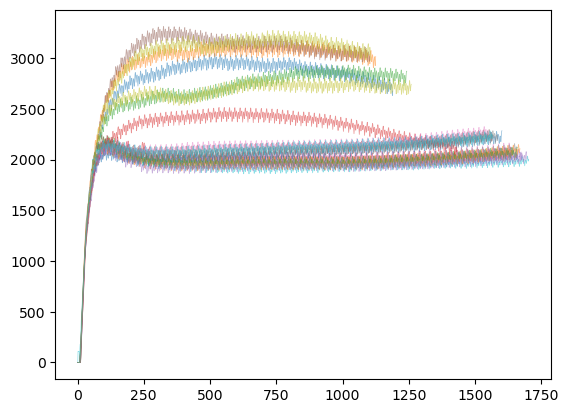

In [21]:
for i in range(20):
    key = res_train_sorted.key.iloc[i]
    c = kurven[key]
    plt.plot(c.ms, c.power, linewidth=0.5, alpha=0.5)

In [22]:
print('Kleinste Fehler Training')
res_train_sorted.tail(20)

Kleinste Fehler Training


,key,label,festigkeit,pred,abs_err,p_mean,p_q25,p_50,p_q75,p_max,...,f_q75,f_max,f_std,d_mean,d_q25,d_q50,d_q75,d_max,d_std,ti
197,ok_1766,0,2890.000000,2896.442524,6.442524,-0.024029,-0.014585,-0.123958,-0.154988,-0.167354,...,0.031510,-0.719667,-0.419909,-0.326974,-0.419203,-0.362350,-0.266766,-0.211079,-0.176950,-0.163968
231,near_ok_sonowechsel_2960,1,2622.932617,2629.283471,6.350854,-0.334026,-0.331606,-0.428977,-0.439083,-0.430343,...,0.972627,1.622743,0.356722,-0.364237,-0.377735,-0.343973,-0.355636,-0.403665,-0.417833,0.214188
196,ok_1765,0,2860.000000,2866.164797,6.164797,0.032768,0.065712,-0.052388,-0.104893,-0.191037,...,0.031510,-0.362755,0.000159,-0.246307,-0.336330,-0.307219,-0.213462,-0.106032,-0.185869,-0.226994
68,ok_1637,0,2850.000000,2856.075989,6.075989,-0.048382,-0.057555,-0.130437,-0.156399,-0.210410,...,-1.380105,-1.076671,-1.168759,-0.493978,-0.481393,-0.490988,-0.497827,-0.491204,-0.506541,-0.138016
533,fehler_terminversatz_2443,4,2118.234619,2124.076170,5.841551,-0.705678,-0.721463,-0.809761,-0.788401,-0.747696,...,-0.909487,-1.255128,-1.591521,-0.475520,-0.730051,-0.527742,-0.284540,-0.018493,0.213902,0.736934
189,ok_1758,0,2880.000000,2874.247861,5.752139,-0.094237,-0.081899,-0.188723,-0.221275,-0.268338,...,0.031510,-0.362755,-0.335452,-0.208221,-0.315587,-0.252089,-0.160123,-0.071016,-0.121091,-0.082405
552,fehler_terminversatz_2462,4,2029.821655,2035.295095,5.473440,-0.863674,-0.929096,-0.986764,-0.899617,-0.793846,...,-1.144856,-0.541211,-1.095376,-0.163289,-0.439926,-0.288861,-0.017950,0.349154,0.285396,0.985331
242,near_ok_sonowechsel_2971,1,2623.455322,2618.441042,5.014280,-0.426883,-0.439831,-0.515299,-0.514833,-0.525651,...,0.972627,1.444287,0.723436,-0.374943,-0.377756,-0.362350,-0.391184,-0.438681,-0.469974,0.336533
44,ok_1613,0,2840.000000,2835.026615,4.973385,0.103569,0.132468,0.017551,-0.045074,-0.074286,...,-1.644745,-1.433584,-0.082635,-0.293171,-0.294863,-0.288861,-0.320088,-0.368649,-0.452793,-0.304850
151,ok_1720,0,2870.000000,2874.666064,4.666064,-0.083607,-0.068310,-0.169963,-0.199157,-0.219905,...,0.502128,-0.184298,0.183053,-0.071129,-0.108354,-0.105074,-0.089045,-0.088541,-0.274417,-0.097235


In [23]:
print('Vorhersagefehler Test')
res_test_sorted.head(20)

Vorhersagefehler Test


,key,label,festigkeit,pred,abs_err,p_mean,p_q25,p_q50,p_q75,p_max,...,f_q75,f_max,f_std,d_mean,d_q25,d_q50,d_q75,d_max,d_std,ti
349,fehler_oel_2057,2,1930.000000,1437.021451,492.978549,1.198425,1.281984,1.190025,1.086965,0.985777,...,1.207876,1.087374,1.195071,-0.557253,-0.481372,-0.546119,-0.586697,-0.631267,-0.634645,-1.291023
300,fehler_oel_2008,2,193.000000,634.631505,441.631505,1.773947,1.863972,1.839250,1.726391,1.708750,...,0.266879,0.373457,0.845321,-0.819794,-0.605712,-0.729888,-0.888853,-1.103978,-0.955846,-1.684010
441,fehler_leitungsversatz_2551,3,2367.425537,2632.269830,264.844293,-0.938131,-0.977104,-0.480318,-0.500812,-0.614729,...,0.031510,-0.719667,-1.203920,2.153309,2.150477,2.302298,2.239354,2.082448,2.497491,1.107676
316,fehler_oel_2024,2,364.000000,104.115215,259.884785,2.237915,2.312083,2.332994,2.282925,2.266902,...,0.737377,1.087374,1.700878,-0.883129,-0.626435,-0.766641,-0.977723,-1.209025,-1.034714,-1.954651
199,ok_1768,0,3040.000000,2783.997097,256.002903,0.058654,0.069272,-0.025493,-0.063958,-0.066797,...,0.031510,-0.005842,0.489937,-0.105321,-0.066908,-0.123432,-0.160123,-0.228587,-0.429124,-0.256654
10,ok_1579,0,2590.000000,2820.841862,230.841862,0.037683,0.045995,-0.065672,-0.106673,-0.050838,...,-2.350613,-1.612040,-1.156655,-0.644849,-0.626435,-0.638003,-0.622245,-0.648792,-0.557769,-0.234409
212,near_ok_sonowechsel_2941,1,2301.888672,2509.781025,207.892354,-0.398404,-0.386227,-0.487216,-0.525772,-0.372970,...,0.737377,1.265830,0.693652,-0.424538,-0.336330,-0.380727,-0.480053,-0.648792,-0.703107,0.299459
368,fehler_oel_2076,2,0.000000,202.968539,202.968539,2.147532,2.310606,2.268975,2.142495,2.107373,...,0.972627,1.265830,1.751958,-0.748736,-0.522819,-0.693134,-0.835531,-0.893902,-0.832779,-1.902747
539,fehler_terminversatz_2449,4,2219.936523,2422.354866,202.418343,-0.541670,-0.536889,-0.637861,-0.655481,-0.574703,...,-0.968329,-0.362755,-0.730801,-0.404300,-0.543542,-0.435858,-0.320088,-0.246094,-0.190420,0.495952
439,fehler_leitungsversatz_2549,3,2856.765625,2676.223548,180.542077,-0.528982,-0.301594,-0.365936,-0.401577,-0.546496,...,0.031510,-0.541211,1.400109,2.059840,2.150477,1.953137,1.866102,1.697275,1.189755,0.477415


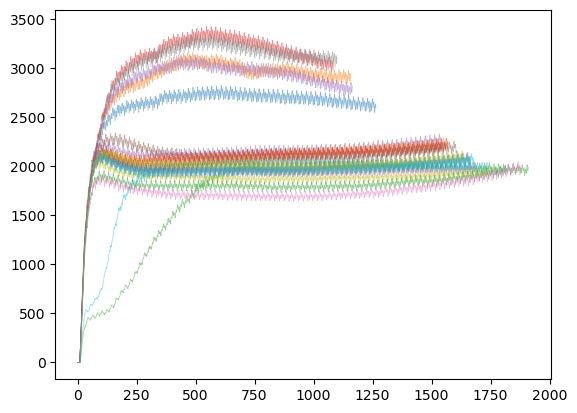

In [24]:
for i in range(20):
    key = res_test_sorted.key.iloc[i]
    c = kurven[key]
    plt.plot(c.ms, c.power, linewidth=0.5, alpha=0.5)

Untersuchung, inwieweit die Kurven mit den meisten Fehlern von der allgemeinen Verteilung der Features abweichen

In [25]:
def boxplot_by_label(df, label, points):
    fig, ax = plt.subplots()
    # Boxplot der Features
    err_max = points['abs_err'].max()
    err_min = points['abs_err'].min()
    err_range = err_max-err_min
    df.loc[df.label == label].iloc[:,5:].plot(kind='box', title='label {}'.format(label), figsize=(15,8), ax=ax)
    sel_points = points.loc[points.label==label]
    #print(sel_points)
    # Statistische Features der Ausreißer als Punkte ergänzt
    cmap = plt.colormaps['rainbow']
    colors = cmap(np.linspace(0, 1, len(sel_points)))
    for ci, (_, row) in enumerate(sel_points.iterrows()):
        plt.scatter(np.arange(1, 20), row[5:], color=cmap((row['abs_err']-err_min)/err_range))
    plt.colorbar(plt.cm.ScalarMappable(norm= matplotlib.colors.Normalize(vmin=err_min, vmax=err_max), cmap=cmap), ax=ax)

Erstmal für die Trainingsdaten

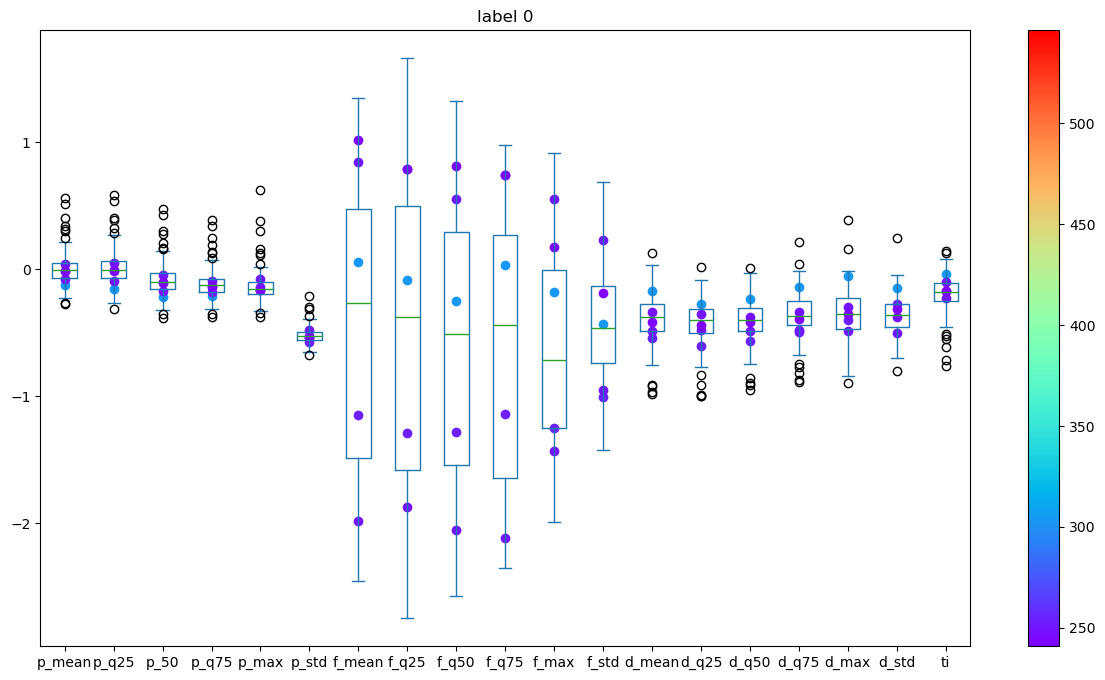

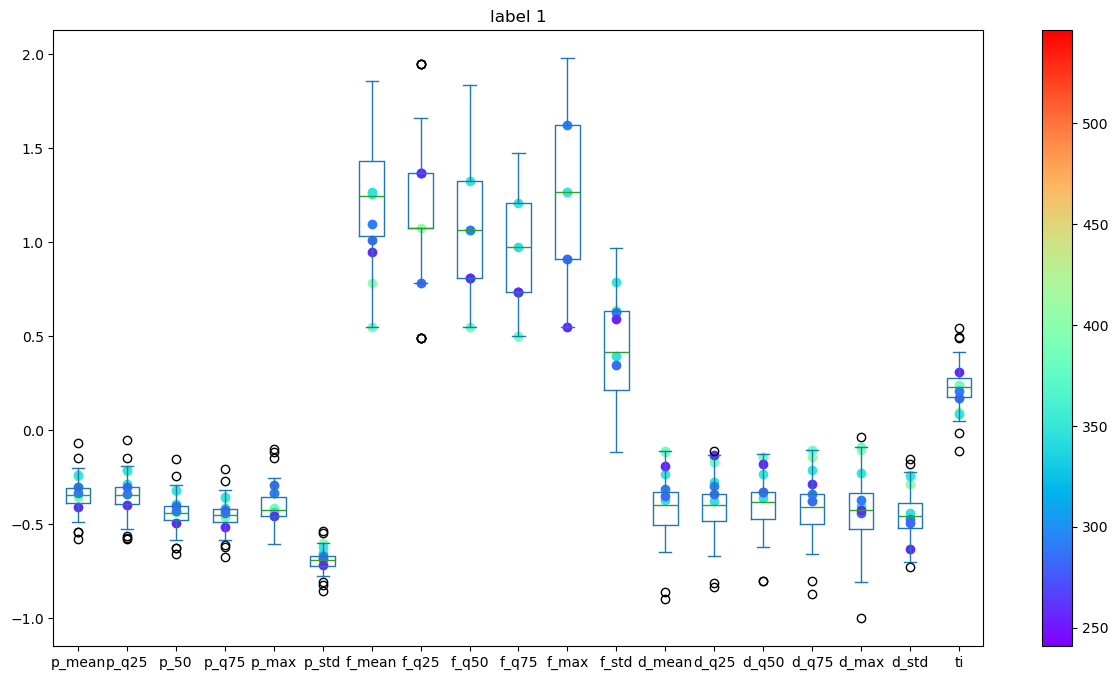

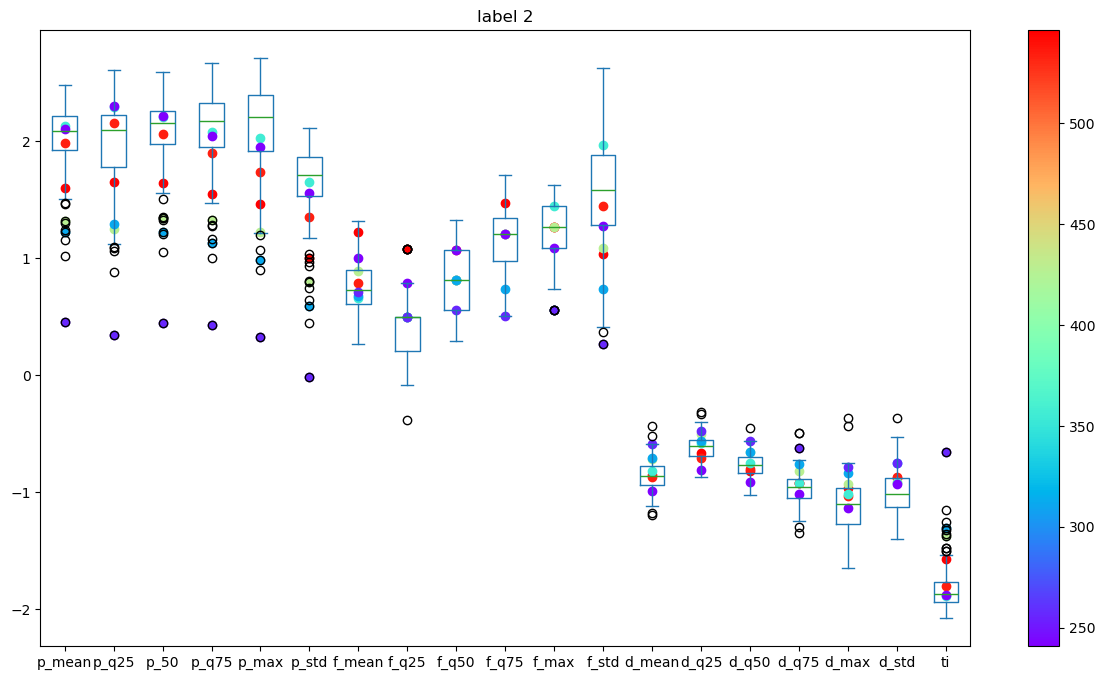

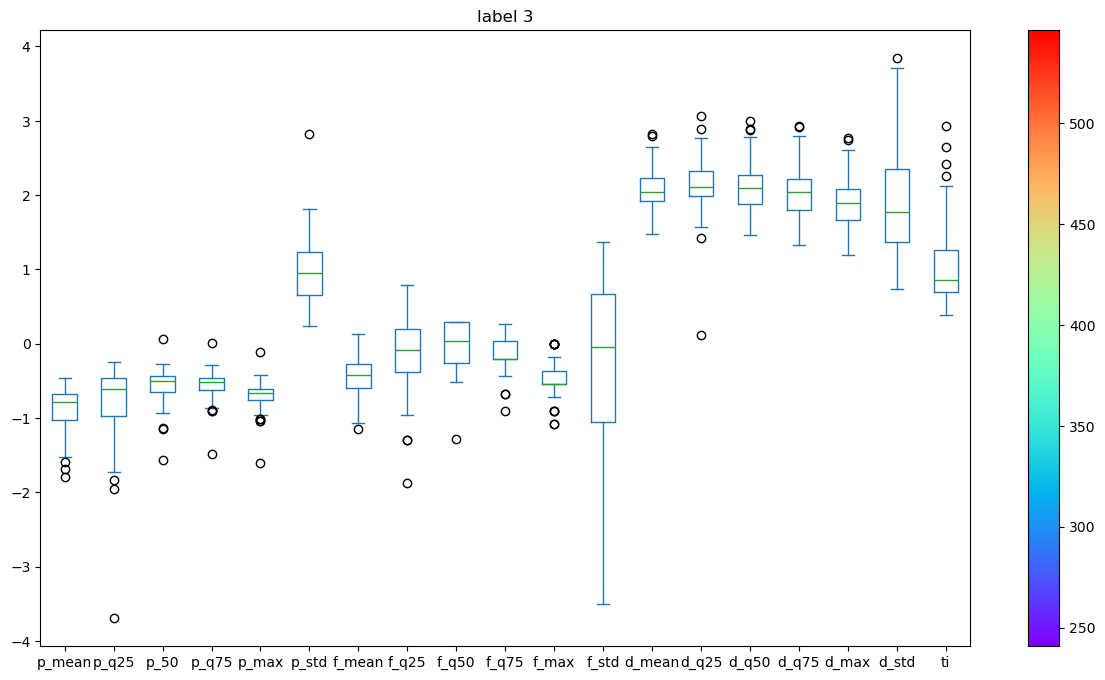

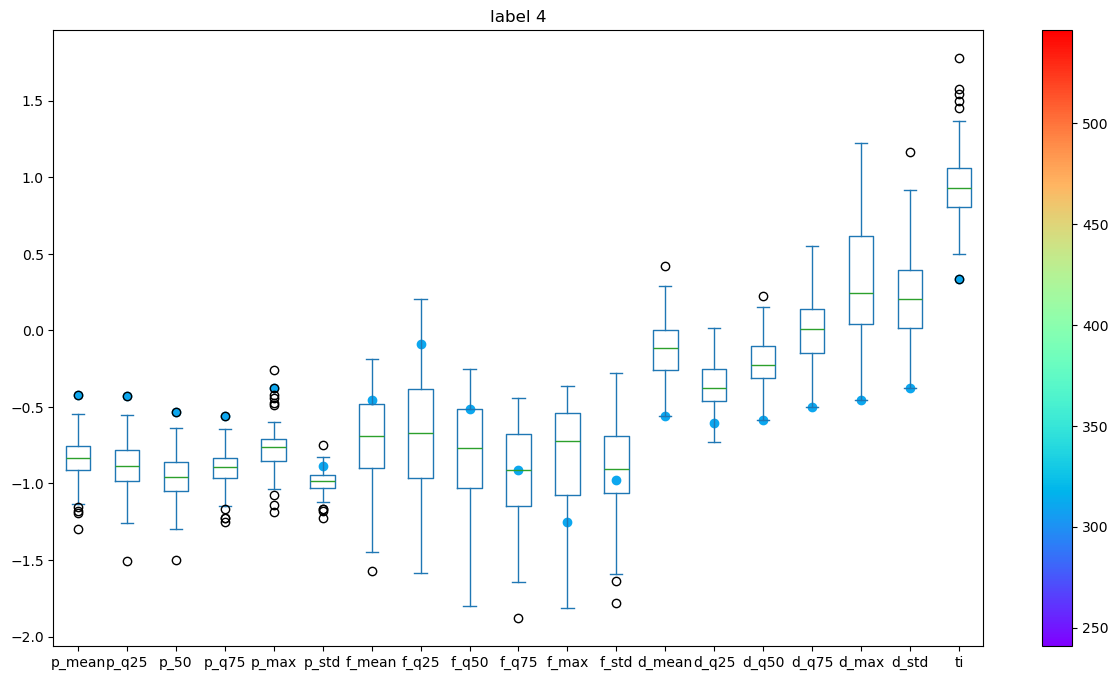

In [26]:
for label in range(5):
    #plt.subplot(5, 1, label+1)
    boxplot_by_label(result_train, label, res_train_sorted.head(20))

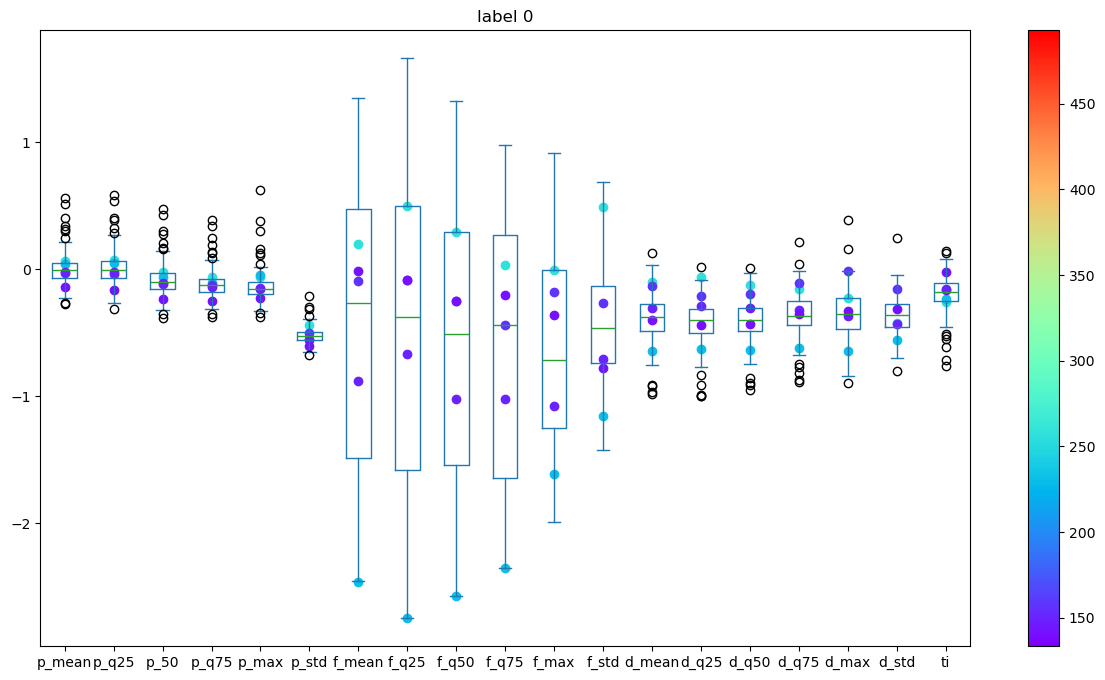

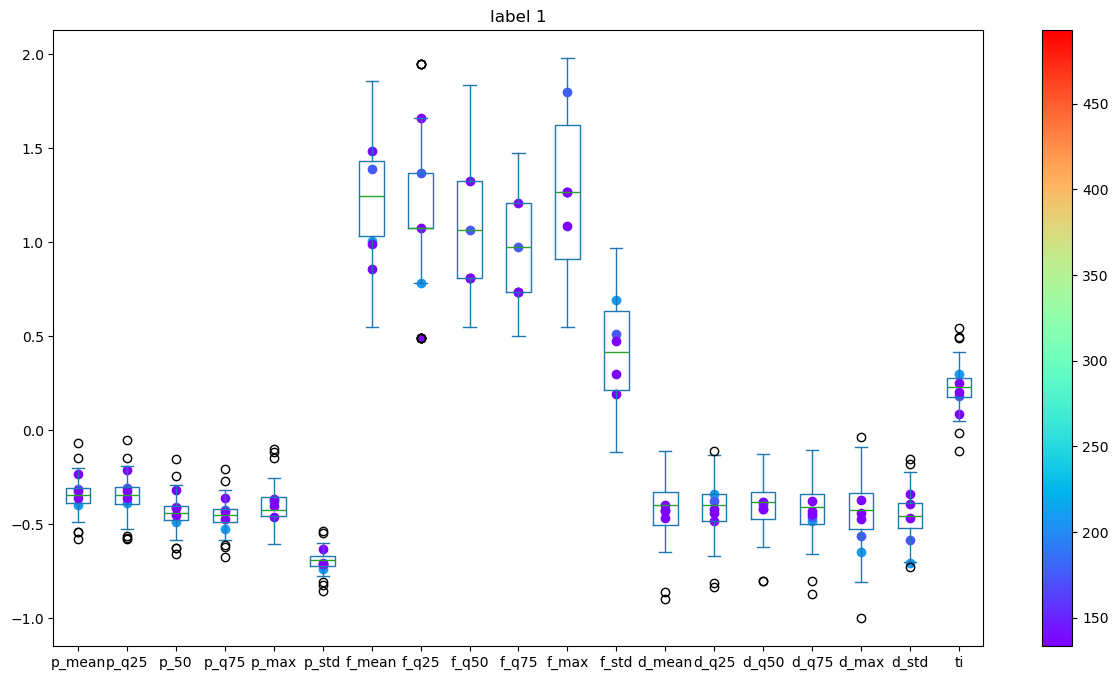

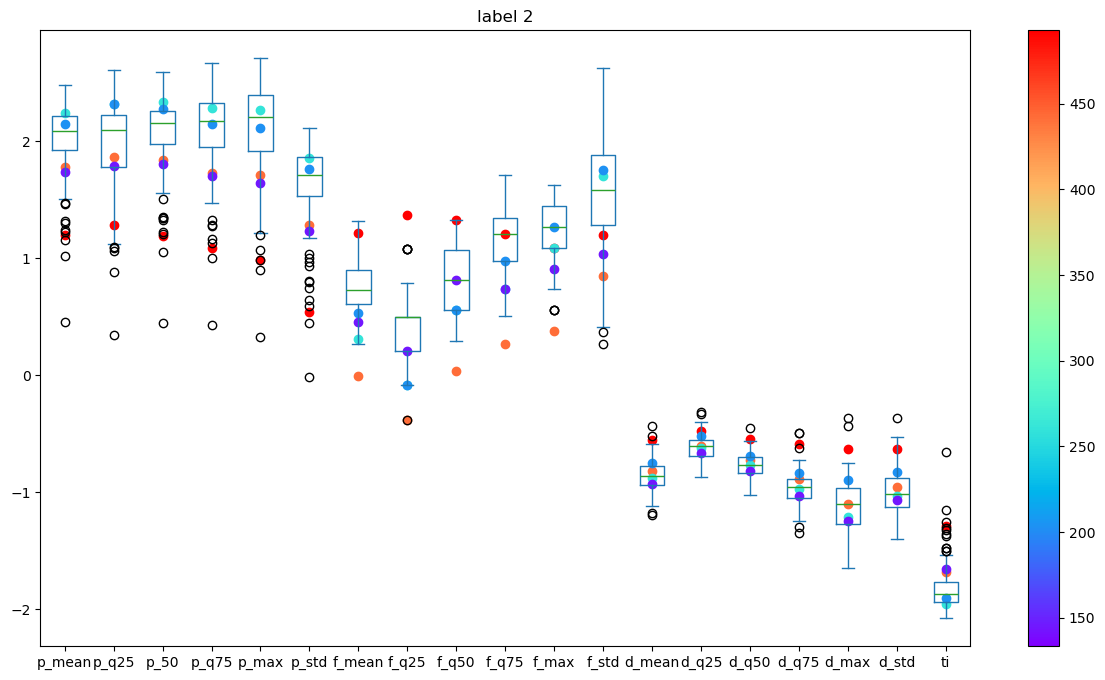

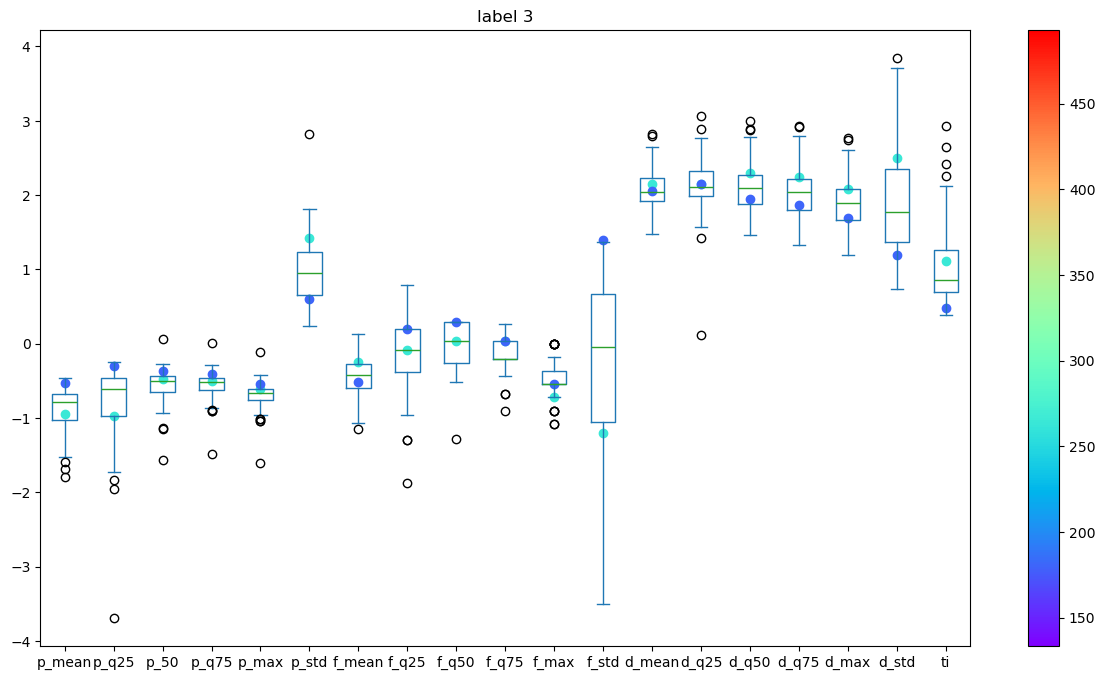

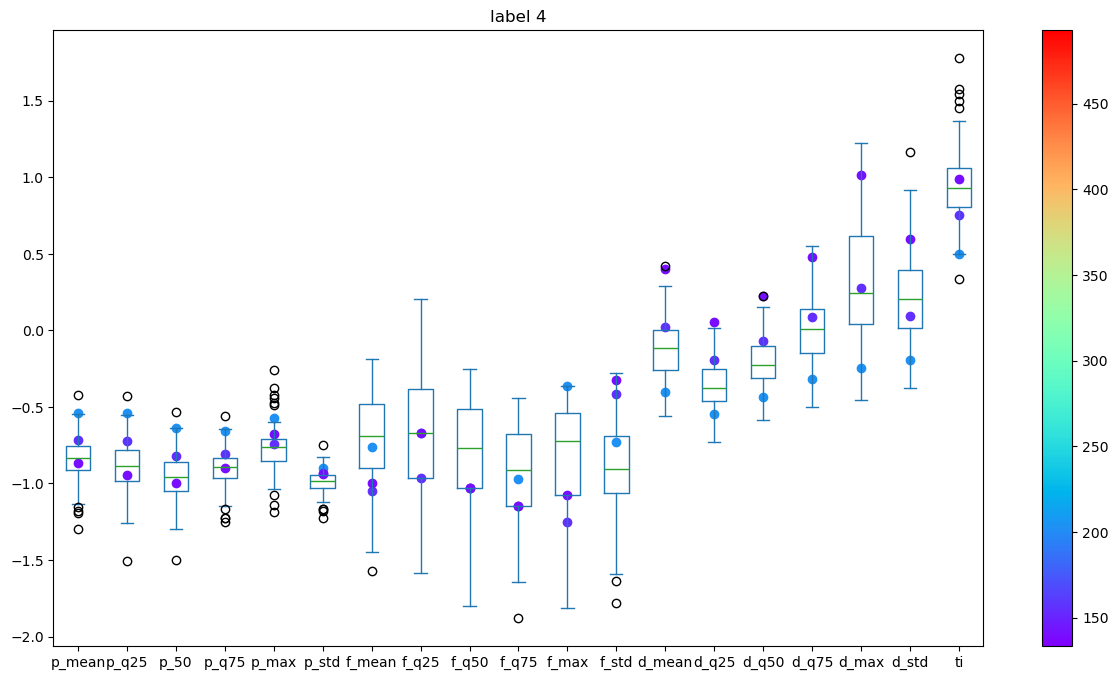

In [27]:
for label in range(5):
    #plt.subplot(5, 1, label+1)
    boxplot_by_label(result_train, label, res_test_sorted.head(20))